## Computational Homework 9: Principal Components Analysis and Regression

In this assignment, we will work through an example of performing principal components analysis in Python, in particular focusing on the case when the data matrix $X$ has columns which are nearly linearly dependent. We will then introduce an application of PCA to regression, called principal components regression (PCR), which can be a useful approach the $X$ is approximately low-rank (i.e., in the presence of multicollinearity). 

### Part 1: PCA

For the sake of this assignment, we will use a simulated dataset which is generated in the following cell.

In [80]:
import numpy as np 
np.random.seed(42)

n, p = 100, 30
U = np.linalg.qr(np.random.normal(size=(n,p)))[0] 
D = np.diag([10*np.exp(-0.2*t) for t in range(1,p+1)]) 
X = U@D

**Problem 1.** (Prepping the data for PCA). Using the data matrix $X$ defined in the cell above, perform the following:

1. Construct the centered data matrix $X_c$, whose columns have mean zero (note, you should be able to use the centering matrix $H = I - \frac{1}{n}\mathbb{1}\mathbb{1}^\top$ to do this easily).
2. Using $X_c$ defined above, define compute the sample covariance matrix $C = \frac{1}{n}X_c^\top X_c$.

In [81]:
Center = np.eye(n) + np.ones(shape=(n,n))/n 
Xc = Center@X 
C = Xc.T@Xc/n

**Problem 2.** (Performing PCA). Now that you've computed the covariance matrix $C$, we can perform PCA by computing its eigenvalue decomposition. To do this using numpy, you can use the function `np.linalg.eigh` -- this will return two arrays, the first is a $p\times 1$ array containing the eigenvalues, and the second is a $p\times p$ array containing the eigenvectors. Make a scatterplot of the eigenvalues, sorted from largest to smallest (this usually called a "scree plot"). What do you notice about this scatterplot? What does it say about the dimensionality of the data? Is there any indication of colinearity in the columns of $X$?

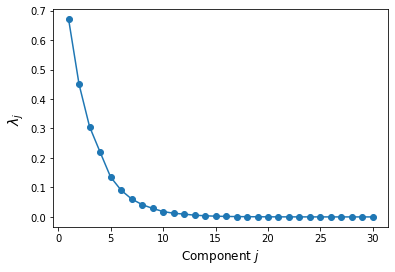

In [88]:
import matplotlib.pyplot as plt 

vals, vecs = np.linalg.eigh(C)
sorted_ix = np.argsort(vals)[::-1]
vals = vals[sorted_ix]
vecs = vecs[:,sorted_ix]
plt.plot(range(1,p+1), vals, marker='o')
plt.xlabel("Component $j$", fontsize=12)
plt.ylabel("$\lambda_j$", fontsize=14)
plt.show()

**Problem 3.** (Evaluating PCA, choosing the number of components). Next, we will create two plots which will help us evaluate how many components we might want to keep for an analysis. To do this, we will a plot of the cumulative proportion of variance explained by the first $j$ components. To do this, compute 

$$
p_j = \frac{\sum_{k=1}^j \lambda_k}{\sum_{l=1}^p \lambda_l}
$$

where $\lambda_k$ is the $k^{th}$ eigenvalue (in sorted order, so $\lambda_1 > \lambda_2 > \cdots > \lambda_p$). Using this plot, determine the minimum number of components needed to explain $90\%$ of the variance in the original data.

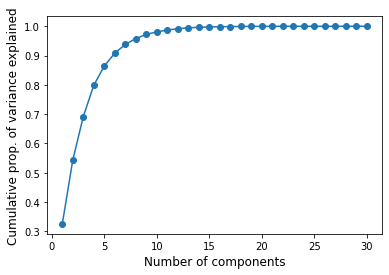

In [89]:
prop_variance = vals/np.sum(vals)
prop_variance = np.cumsum(prop_variance)

plt.plot(range(1,p+1), prop_variance, marker='o')
plt.xlabel("Number of components", fontsize=12)
plt.ylabel("Cumulative prop. of variance explained", fontsize=12)
plt.show()

### Part 2: Principal components regression

Previously in this class, we've discussed what can happen when we have some features which are either exactly or very close to being linear combinations of each other. When this happens, we sometimes say that there is _multicolinearity_ present in the data (though this term is usually loosely defined). We've also seen that in these situations, the usual least squares estimator $\hat{\beta} = (X^\top X)^{-1}X^\top y$ is unstable, because the matrix $(X^\top X)^{-1}$ either doesn't exist, or contains numerically very large values that result in inflated variances of the coefficients.

So far, we've discussed a few ways of dealing with this problem via regularization (i.e. Ridge regression and LASSO). Here, we show that principal components analysis offers another solution. For this, we will continue with the data matrix $X$ we defined above, and also create a vector of responses.

In [86]:
beta_star = np.random.normal(size=p)
y = np.dot(X, beta_star) + 0.5*np.random.normal(size=n)

**Problem 1.** (Performing PCR). Principal components analysis works as follows. Recall that given the eigenvalue decomposition $C = U\Lambda U^\top$ of the covariance matrix, we can comptue the $j^{th}$ principal component by projecting $X$ onto the $j^{th}$ eigenvector (i.e. the $j^{th}$ column of $U$):

$$
z_j = X u_j \in \mathbb{R}^n. 
$$

In principal components regression, we first select $k\leq p$ of the principal components and forming the $n\times k$ data matrix 

$$
Z_{k} = \begin{bmatrix} | & | & & |\\ z_1 & z_2 & \cdots & z_k\\ | & | & & |\end{bmatrix} \in \mathbb{R}^{n\times k}
$$

and performing least squares using this data matrix instead to get the coefficients 

$$
\hat{\beta}_{PCR}(k) = (Z_{k}^\top Z_{k})^{-1}Z_{k}^\top y \in \mathbb{R}^k. 
$$

Perform PCR using the value of $k$ determined in Problem 3 of Part 1 in this assignment (i.e. the $k$ which describes $90\%$ of the variance in the data).

In [90]:
def fit_ols(X, y):
    return np.dot(np.linalg.pinv(X),y)

def mse(y, y_hat):
    return np.mean((y_hat-y)**2)


**Problem 2.** (Selecting the number of components to keep). One way to select the number of components that we should use in PCR is by doing essentially what we just did in the previous part, i.e. plot the cumulative proportion of variance, and select a value of $k$ that seems to capture a sufficiently large proportion of the variance in the data. However, we can also use cross-validation to do this.

For $k \in \{1,2,3,\dots,30\}$, perform 5-fold cross validation with PCR and plot the average out-of-sample MSE from this as a function of $k$ (see Homework 6 if you need a refresher on cross validation). What value of $k$ appears best here? Referring back to the cumulative proportion of variance plot from Part 1, what proportion of variance in the data is accounted for at this value?

_Note:_ For this problem, you should compute the principal components using only the data in the training set for each fold, i.e. recompute an eigenvalue decomposition for the training data at each step.

best value of k is 19, which achieves an out-of-sample MSE of 0.2646292893032684


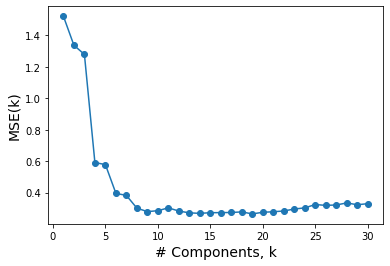

In [104]:
def k_fold_split(n=1000, k=5):
    ix = range(n)
    test_ix = np.array_split(ix, k)
    train_ix = [[j for j in ix if j not in tix] for tix in test_ix]
    return train_ix, test_ix

all_mses = []
train_ix_all, test_ix_all = k_fold_split(n=100, k=5)
for train_ix, test_ix in zip(train_ix_all, test_ix_all):
    X_train, y_train, X_test, y_test = X[train_ix], y[train_ix], X[test_ix], y[test_ix]
    Center = np.eye(X_train.shape[0]) - np.ones(shape=(X_train.shape[0], X_train.shape[0]))/X_train.shape[0]
    Xc_train = Center@X_train
    C = Xc_train.T@Xc_train/n
    vals, vecs = np.linalg.eigh(C)
    sorted_ix = np.argsort(vals)[::-1]
    vals, vecs = vals[sorted_ix], vecs[sorted_ix]
    curr_mses = []
    for k in range(1,31):
        Vk = vecs[:,:k]
        Zk_train = X_train@Vk 
        Zk_test = X_test@Vk 
        beta_hat_k = fit_ols(Zk_train, y_train)
        y_hat_k = Zk_test@beta_hat_k 
        curr_mses.append(mse(y_hat_k, y_test))
    all_mses.append(curr_mses)

all_mses = np.array(all_mses)
all_mses_cv = np.mean(all_mses, axis=0)

print(f"best value of k is {np.argmin(all_mses_cv)+1}, which achieves an out-of-sample MSE of {np.min(all_mses_cv)}")
plt.plot(range(1,31), all_mses_cv, marker='o')
plt.xlabel("# Components, k", fontsize=14)
plt.ylabel("MSE(k)", fontsize=14)
plt.title("Cross validation results for PCR", fontsize=14)
plt.show()

**Problem 3.** (Comparing to Ridge regression). As we mentioned, an PCR can be considered as an alternative to Ridge regression when the data matrix $X$ is poorly conditioned. To compare the performance of PCR vs Ridge regression, perform the same 5-fold cross validation as in the previous problem, but instead fitting Ridge regression models across as range of $\lambda$ values. At the best value of $\lambda$, which model performs better, PCR or Ridge?

best value of lambda is 0.17607555165924657, which achieves an out-of-sample MSE of 0.2594275141266752


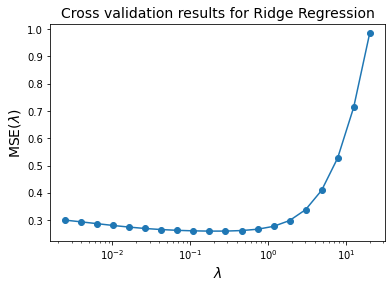

In [107]:
def fit_ridge(X, y, lamb = 0.1):
    return np.dot(np.linalg.inv(X.T@ X + lamb*np.eye(X.shape[1])), np.dot(X.T, y))

all_mses = []
lamb_range = np.exp(np.linspace(-6,3,20))
for train_ix, test_ix in zip(train_ix_all, test_ix_all):
    X_train, y_train, X_test, y_test = X[train_ix], y[train_ix], X[test_ix], y[test_ix]
    curr_mses = []
    for lamb in lamb_range:
        beta_hat_lamb = fit_ridge(X_train, y_train, lamb)
        y_hat_lamb = X_test@beta_hat_lamb
        curr_mses.append(mse(y_hat_lamb, y_test))
    all_mses.append(curr_mses)

all_mses = np.array(all_mses)
all_mses_cv = np.mean(all_mses, axis=0)

print(f"best value of lambda is {lamb_range[np.argmin(all_mses_cv)]}, which achieves an out-of-sample MSE of {np.min(all_mses_cv)}")
plt.plot(lamb_range, all_mses_cv, marker='o')
plt.xlabel("$\lambda$", fontsize=14)
plt.ylabel("MSE($\lambda$)", fontsize=14)
plt.xscale("log")
plt.title("Cross validation results for Ridge Regression", fontsize=14)
plt.show()